In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn


import torch.optim as optim

import sys
sys.path.insert(0, '../libraries/')

import mnist_data_lib
import mnist_vae_lib
import common_utils

# Load data

In [2]:
seed = 9033

In [33]:
np.random.seed(seed)
_ = torch.manual_seed(seed)

# LOAD DATA
print('Loading data')
train_set_labeled, train_set_unlabeled, test_set = \
    mnist_data_lib.get_mnist_dataset_semisupervised(propn_sample = 1.0,
                                                    propn_labeled = 0.1)

train_loader_labeled = torch.utils.data.DataLoader(
                 dataset=train_set_labeled,
                 batch_size=20,
                 shuffle=True)

train_loader_unlabeled = torch.utils.data.DataLoader(
                 dataset=train_set_unlabeled,
                 batch_size=100,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=100,
                shuffle=False)

for batch_idx, d in enumerate(train_loader_labeled):
    data_labeled = d
    break

for batch_idx, d in enumerate(train_loader_unlabeled):
    data_unlabeled = d
    break
    
for batch_idx, d in enumerate(test_loader):
    test_data = d
    break


print('Done.')

Loading data
Done.


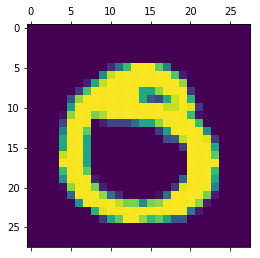

In [4]:
plt.matshow(data_labeled['image'][0, :, :])

In [5]:
slen = data_labeled['image'].shape[-1]

# Define VAE

In [6]:
latent_dim = 5
n_classes = 10

In [7]:
vae = mnist_vae_lib.HandwritingVAE(latent_dim = latent_dim, 
                                    n_classes = n_classes)

In [8]:
# Load results

enc_file = "../mnist_vae_results_aws/mnist_vae5_semisupervised_enc_epoch80"
dec_file = '../mnist_vae_results_aws/mnist_vae5_semisupervised_dec_epoch80'
classifier_file = '../mnist_vae_results_aws/mnist_vae5_semisupervised_classifier_epoch80'

# enc_file = "../mnist_vae_results_aws/mnist_vae4_set_true_class_enc_final"
# dec_file = '../mnist_vae_results_aws/mnist_vae4_set_true_class_dec_final'
# classifier_file = '../mnist_vae_results_aws/mnist_vae4_semisupervised_classifier_epoch70'


vae.encoder.load_state_dict(torch.load(enc_file,
                               map_location=lambda storage, loc: storage))

vae.decoder.load_state_dict(torch.load(dec_file,
                               map_location=lambda storage, loc: storage))

vae.classifier.load_state_dict(torch.load(classifier_file,
                               map_location=lambda storage, loc: storage))


vae.eval()

HandwritingVAE(
  (encoder): MLPEncoder(
    (fc1): Linear(in_features=794, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=128, bias=True)
    (fc4): Linear(in_features=128, out_features=10, bias=True)
  )
  (classifier): Classifier(
    (fc1): Linear(in_features=784, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=9, bias=True)
  )
  (decoder): MLPConditionalDecoder(
    (fc1): Linear(in_features=15, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=128, bias=True)
    (fc4): Linear(in_features=128, out_features=128, bias=True)
    (fc5): Linear(in_features=128, out_features=1568, bias=True)
  )
)

In [9]:
print(vae.parameters)

<bound method Module.parameters of HandwritingVAE(
  (encoder): MLPEncoder(
    (fc1): Linear(in_features=794, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=128, bias=True)
    (fc4): Linear(in_features=128, out_features=10, bias=True)
  )
  (classifier): Classifier(
    (fc1): Linear(in_features=784, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=9, bias=True)
  )
  (decoder): MLPConditionalDecoder(
    (fc1): Linear(in_features=15, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=128, bias=True)
    (fc4): Linear(in_features=128, out_features=128, bias=True)
    (fc5): Linear(in_features=128, out_features=1568, bias=True)
  )
)>


In [10]:
loss_array = np.loadtxt('../mnist_vae_results_aws/mnist_vae4_semisupervisedloss_array.txt')

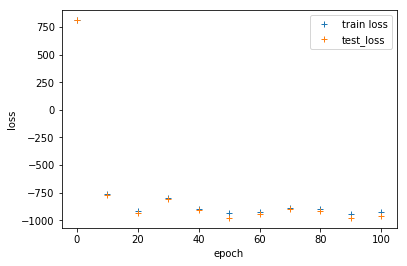

In [11]:
plt.plot(loss_array[0, :], loss_array[1, :], '+')
plt.plot(loss_array[0, :], loss_array[2, :], '+')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(('train loss', 'test_loss'))

In [12]:
vae.loss(data_unlabeled['image'])[0]

tensor(-1496.2599)

In [13]:
vae.loss(test_data['image'])[0]

tensor(-1499.9764)

In [14]:
# check a few train images

In [42]:
class_weights = vae.classifier(data_unlabeled['image'])

z_ind = torch.argmax(class_weights, dim = 1)
z_ind_one_hot = common_utils.get_one_hot_encoding_from_int(z_ind, n_classes)

latent_means, latent_std, latent_samples = \
    vae.encoder_forward(data_unlabeled['image'], z_ind_one_hot)

    
image_mu, image_std = vae.decoder_forward(latent_means, z_ind_one_hot)

In [43]:
class_weights

tensor([[ 6.0423e-09,  6.0423e-09,  6.0423e-09,  6.0423e-09,  4.6541e-04,
          8.1738e-01,  6.0423e-09,  6.0423e-09,  1.8215e-01,  1.3667e-08],
        [ 9.2403e-04,  9.2403e-04,  7.2662e-03,  9.2403e-04,  4.6610e-01,
          5.2016e-01,  9.2403e-04,  9.2403e-04,  9.2403e-04,  9.2403e-04],
        [ 6.6540e-12,  6.6540e-12,  2.8439e-09,  6.6540e-12,  1.5623e-10,
          7.9460e-11,  1.0000e+00,  6.6540e-12,  1.1943e-10,  6.6540e-12],
        [ 1.2715e-08,  1.0000e+00,  1.2715e-08,  9.4827e-07,  1.3581e-07,
          1.2715e-08,  1.4128e-07,  1.2715e-08,  3.7782e-07,  3.9231e-07],
        [ 3.1519e-10,  2.0469e-08,  5.7955e-09,  1.3208e-02,  3.1519e-10,
          3.1519e-10,  3.1519e-10,  9.7118e-01,  5.3617e-08,  1.5612e-02],
        [ 1.4781e-14,  1.4781e-14,  7.2341e-08,  1.4781e-14,  1.4781e-14,
          8.8312e-14,  1.0000e+00,  1.4781e-14,  1.4781e-14,  1.4781e-14],
        [ 4.9754e-08,  9.9997e-01,  1.3292e-07,  3.9187e-06,  1.4097e-07,
          4.9754e-08,  2.1306e-0

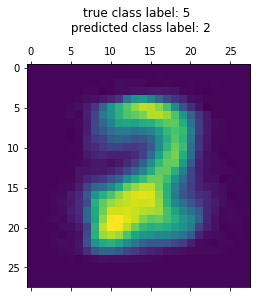

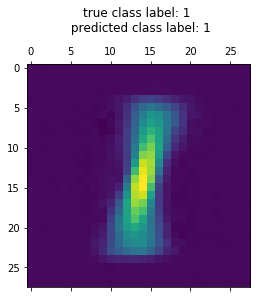

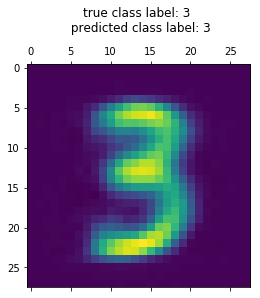

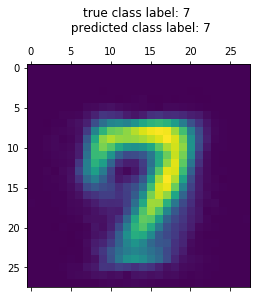

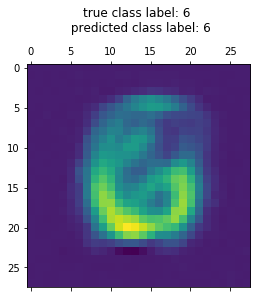

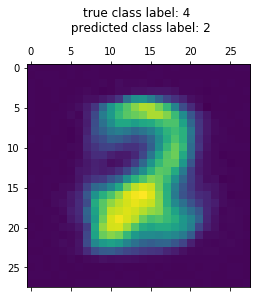

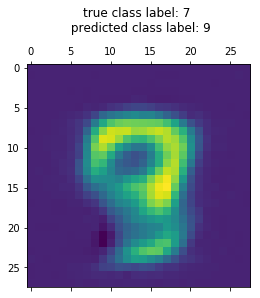

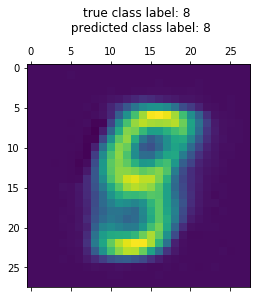

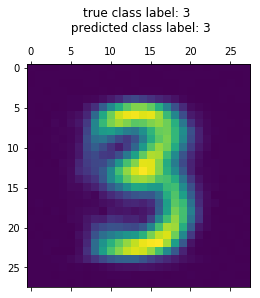

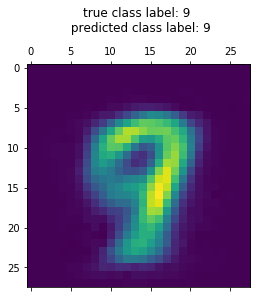

In [44]:
for i in range(20, 30): 
    plt.matshow(image_mu[i, :, :].detach())
    plt.title('true class label: {} \n predicted class label: {}\n'.format(data_unlabeled['label'][i], z_ind[i]))

In [45]:
# check a few test images 

In [46]:
class_weights = vae.classifier(test_data['image'])

z_ind = torch.argmax(class_weights, dim = 1)
z_ind_one_hot = common_utils.get_one_hot_encoding_from_int(z_ind, n_classes)

latent_means, latent_std, latent_samples = \
    vae.encoder_forward(data_unlabeled['image'], z_ind_one_hot)

    
image_mu, image_std = vae.decoder_forward(latent_means, z_ind_one_hot)

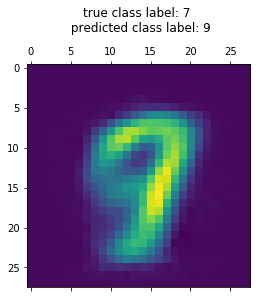

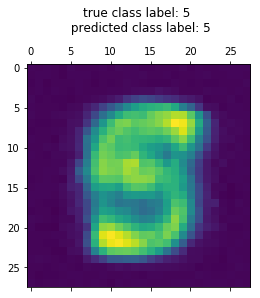

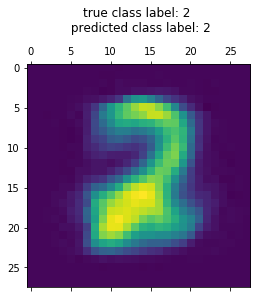

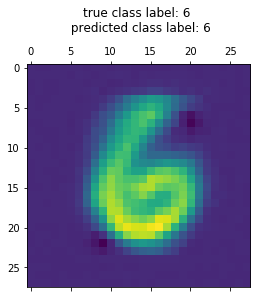

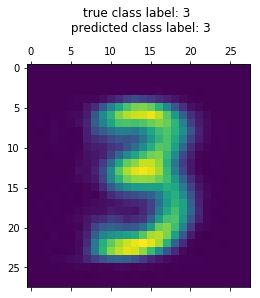

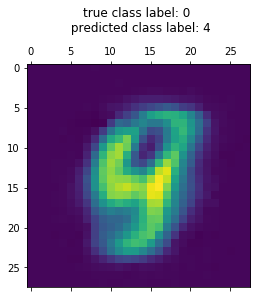

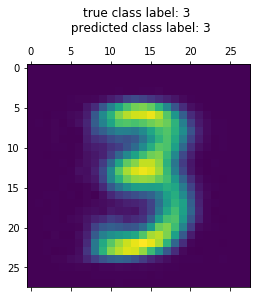

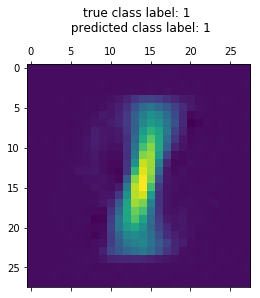

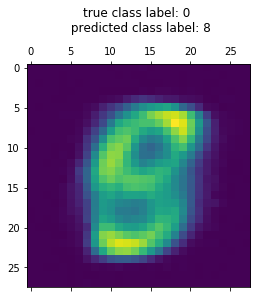

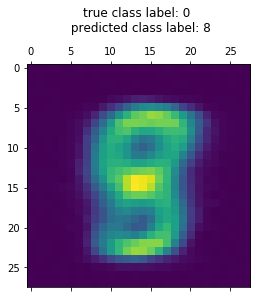

In [47]:
for i in range(10): 
    plt.matshow(image_mu[i, :, :].detach())
    plt.title('true class label: {} \n predicted class label: {}\n'.format(test_data['label'][i], z_ind[i]))

In [48]:
i = 0
n_images = 0.0
accuracy = 0.0

for batch_idx, data in enumerate(train_loader_unlabeled):
    class_weights = vae.classifier(data['image'])

    z_ind = torch.argmax(class_weights, dim = 1)
    
    accuracy += torch.sum(z_ind == data['label']).float()
    # print(accuracy)
    
    i += 1
    n_images += len(z_ind)
    if i == 10: 
        break

print(accuracy / n_images)

tensor(0.7810)


In [49]:
i = 0
n_images = 0.0
accuracy = 0.0

for batch_idx, data in enumerate(test_loader):
    class_weights = vae.classifier(data['image'])

    z_ind = torch.argmax(class_weights, dim = 1)
    
    accuracy += torch.sum(z_ind == data['label']).float()
    # print(accuracy)
    
    i += 1
    n_images += len(z_ind)
    if i == 10: 
        break

print(accuracy / n_images)

tensor(0.7860)


In [24]:
train_loader_unlabeled

In [25]:
image = data_unlabeled['image']

In [26]:
for z in range(vae.n_classes):
    batch_z = torch.ones(image.shape[0]) * z

    image_mu, image_std, latent_means, latent_std, latent_samples = \
        vae.forward_conditional(image, batch_z)

    # likelihood term
    normal_loglik_z = common_utils.get_normal_loglik(image, image_mu,
                                            image_std, scale = False)

    print(normal_loglik_z[0])
    # print(torch.sum(latent_means ** 2))

tensor(984.1842)
tensor(984.1842)
tensor(984.1842)
tensor(984.1842)
tensor(984.1842)
tensor(984.1842)
tensor(984.1842)
tensor(984.1842)
tensor(984.1842)
tensor(984.1842)


In [27]:
foo = torch.rand((3, 5, 5))
foo_view = foo.view(-1, 25)

In [31]:
for i in range(foo.shape[0]): 
    a = torch.sum(foo[i, :, :] ** 2)
    b = torch.sum(foo[i, :] ** 2)
    print('a: {}, b: {}'.format(a, b))
    assert a == b

a: 9.629755973815918, b: 9.629755973815918
a: 9.227524757385254, b: 9.227524757385254
a: 7.633460998535156, b: 7.633460998535156
